Se importan las librerías:
* numpy: Para la manipulación de los arreglos.
* matplotlib: Para la generación de la gráfica.
* pandas: Para cargar los datos del CSV.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Se cargan los datos desde el archivo CSV.

In [46]:
df = pd.read_csv('./polynomial-regression.csv')
X = df.iloc[:, 0].values
Y = df.iloc[:, 1].values
df.dtypes

araba_fiyat      int64
araba_max_hiz    int64
dtype: object

Se define la clase con los métodos para el método de validación **Leave one out**.

In [47]:
class LeaveOneOut:
  def iter_test_indices (self, X):
    return range(len(X))

  def iter_test_masks(self, X=None):
    for test_index in self.iter_test_indices(X):
      test_mask = np.zeros(len(X), dtype=bool)
      test_mask[test_index] = True
      yield test_mask

  def split(self, X):
    indices = np.arange(len(X))
    for test_index in self.iter_test_masks(X):
      train_index = indices[np.logical_not(test_index)]
      test_index = indices[test_index]
      yield train_index, test_index

Se crea la clase `LinearRegression` la cuál se encarga de hacer la optimización y predicción. `PolynomialLinearRegression` no es más que un wrapper de `LinearRegression` que se encarga de convertir el arreglo a una matriz.

In [48]:
class LinearRegression:
  def __init__ (self):
    self.slope = None
    self.intercept = None

  def fit (self, X, Y):
    # Calcular la matriz de coeficientes
    coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
    # Separar la intersección (ordenada al origen) y los coeficientes polinomiales
    self.intercept = coefficients[0]
    self.slope = coefficients[1:]

  def predict(self, X):
    return  np.dot(X, self.slope) + self.intercept

class PolynomialRegression (LinearRegression):
  def __init__ (self, degree=1):
    super().__init__()
    self.degree = degree

  def fit_transform(self, X):
    # Se transforma el arreglo original en una matriz polinomial
    return np.column_stack([X ** d for d in range(1, self.degree + 1)])

  def fit (self, X, Y):
    X_poly = self.fit_transform(X)
    # Añadir una columna de unos para el término independiente en la matriz
    X_poly = np.column_stack([np.ones(X_poly.shape[0]), X_poly])
    super().fit(X_poly, Y)

  def predict(self, X):
    X_poly = self.fit_transform(X)
    return super().predict(X_poly)

Se define la función MSE para poder calcular el error

In [49]:
def mean_squared_error(y_true, y_predicted):
    return np.sum((y_true-y_predicted)**2) / len(y_true)

Usando **Leave one out** y apoyandonos de **MSE** obtenemos la instancia para regresión lineal con el menor margen de error.

In [50]:
leave_one_out = LeaveOneOut()
MIN_ERROR = np.Inf
BEST_PR = None
errors = []
for train_index, test_index in leave_one_out.split(X):
  PR = PolynomialRegression(4)
  X_train, X_test = X[train_index], X[test_index]
  Y_train, Y_test = Y[train_index], Y[test_index]
  PR.fit(X_train, Y_train)
  Y_pred = PR.predict(X_test)
  error = mean_squared_error(Y_test, Y_pred)
  errors.append(error)
  if error < MIN_ERROR:
    MIN_ERROR = error
    BEST_PR = PR

print(f'Average MSE: {np.mean(errors)}')
print(f'Best slope: {BEST_PR.slope}.\nBest intercept: {BEST_PR.intercept}.')

Average MSE: 516951.13969465654
Best slope: [ 7.58590837e-01 -8.29258846e-04  3.61276950e-07 -5.34744206e-11].
Best intercept: 129.59471435853158.


Gráficamos los puntos originales del CSV y una línea con los puntos generados desde el valor mínimo al máximo de X en pasos de 10 unidades.

(294,)


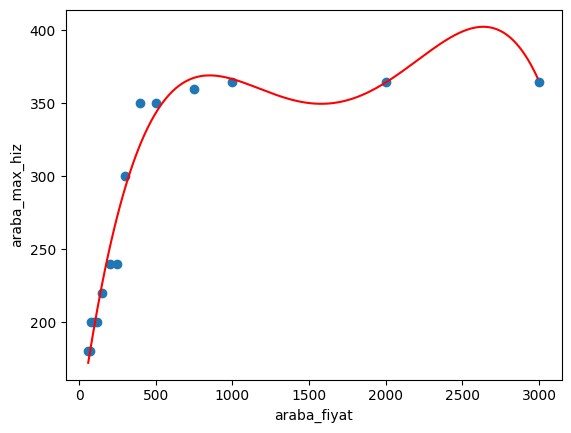

In [51]:
X_min = X.min()
X_max = X.max()
xx = np.arange(X_min, X_max, 10)
print(xx.shape)

plt.scatter(X, Y)
plt.plot(xx, BEST_PR.predict(xx), c="red")
plt.xlabel('araba_fiyat')
plt.ylabel('araba_max_hiz')
plt.show()